In [2]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
import os
import imageio
import scipy.io

# 이미지 파일이 있는 폴더 경로
image_folder = '이미지_폴더_경로'  # 실제 이미지 파일이 있는 폴더 경로로 수정 필요

# .mat 파일로 저장할 변수명
mat_variable_name = 'images'

# 이미지 파일 목록 읽기
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# 이미지 데이터를 저장할 리스트 초기화
images = []

# 모든 이미지 파일에 대해 반복
for image_file in image_files:
    # 이미지 파일 읽기
    img_path = os.path.join(image_folder, image_file)
    img = imageio.imread(img_path)
    
    # 이미지 데이터를 리스트에 추가
    images.append(img)

# 이미지 데이터를 .mat 파일로 저장
mat_data = {mat_variable_name: images}
scipy.io.savemat('test_images.mat', mat_data)

print('이미지 데이터를 test_images.mat 파일로 저장 완료')


In [3]:
# Set random state

np.random.seed(20)

In [4]:
# Load the data

train_raw = loadmat('train_32x32.mat')
test_raw = loadmat('test_32x32.mat')

In [5]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [6]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [7]:
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


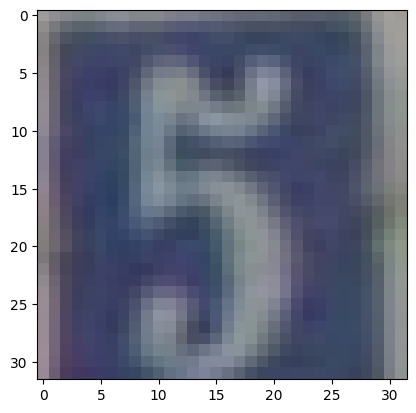

Label:  [5]


In [8]:
# Plot a random image and its label

plt.imshow(train_images[13529])
plt.show()

print('Label: ', train_labels[13529])

In [9]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [10]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [11]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [12]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [13]:
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [14]:
y_val.shape

(10989, 10)

In [15]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [16]:
# Define auxillary model

keras.backend.clear_session()

aux_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

lr_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(lr=1e-4, amsgrad=True)
aux_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [17]:
# Fit model in order to determine best learning rate

history = aux_model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[lr_schedule])

Epoch 1/30


/var/folders/fr/phrsn26j1xq_xzdmg1t4v5600000gn/T/ipykernel_63426/370011484.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = aux_model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),


487/487 [==============================] - 75s 151ms/step - loss: 2.3066 - accuracy: 0.1612 - val_loss: 2.2165 - val_accuracy: 0.1962 - lr: 1.0000e-04
Epoch 2/30
487/487 [==============================] - 71s 146ms/step - loss: 2.0223 - accuracy: 0.2664 - val_loss: 1.2669 - val_accuracy: 0.5809 - lr: 1.2589e-04
Epoch 3/30
487/487 [==============================] - 74s 151ms/step - loss: 1.2664 - accuracy: 0.5759 - val_loss: 0.6165 - val_accuracy: 0.8155 - lr: 1.5849e-04
Epoch 4/30
487/487 [==============================] - 73s 149ms/step - loss: 0.8862 - accuracy: 0.7162 - val_loss: 0.4640 - val_accuracy: 0.8575 - lr: 1.9953e-04
Epoch 5/30
487/487 [==============================] - 79s 162ms/step - loss: 0.7116 - accuracy: 0.7765 - val_loss: 0.3758 - val_accuracy: 0.8870 - lr: 2.5119e-04
Epoch 6/30
487/487 [==============================] - 82s 168ms/step - loss: 0.6003 - accuracy: 0.8156 - val_loss: 0.3308 - val_accuracy: 0.9011 - lr: 3.1623e-04
Epoch 7/30
487/487 [===================

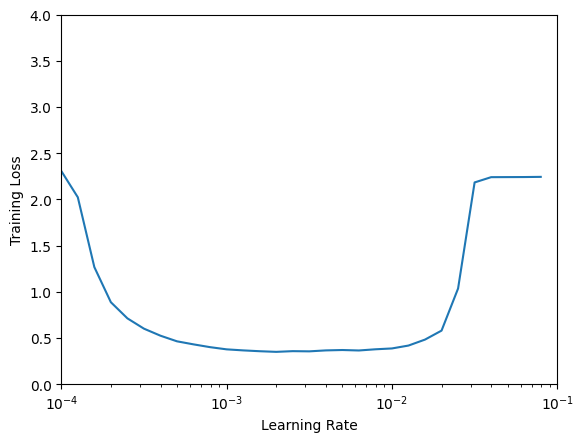

In [18]:
# Plot Learning Rate vs. Loss

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 4])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.show()

In [19]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   'best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

In [21]:
# Fit model in order to make predictions

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70


/var/folders/fr/phrsn26j1xq_xzdmg1t4v5600000gn/T/ipykernel_63426/3044707415.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),


487/487 [==============================] - 77s 157ms/step - loss: 2.1634 - accuracy: 0.2102 - val_loss: 1.7639 - val_accuracy: 0.3651
Epoch 2/70


/Users/yoosukyeong/mambaforge/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


487/487 [==============================] - 74s 152ms/step - loss: 1.5651 - accuracy: 0.4306 - val_loss: 0.8524 - val_accuracy: 0.7351
Epoch 3/70
487/487 [==============================] - 76s 156ms/step - loss: 0.9880 - accuracy: 0.6629 - val_loss: 0.5145 - val_accuracy: 0.8473
Epoch 4/70
487/487 [==============================] - 75s 154ms/step - loss: 0.5443 - accuracy: 0.8401 - val_loss: 0.3618 - val_accuracy: 0.8972
Epoch 5/70
487/487 [==============================] - 77s 158ms/step - loss: 0.4292 - accuracy: 0.8755 - val_loss: 0.2714 - val_accuracy: 0.9223
Epoch 6/70
487/487 [==============================] - 80s 165ms/step - loss: 0.3827 - accuracy: 0.8913 - val_loss: 0.2625 - val_accuracy: 0.9297
Epoch 7/70
487/487 [==============================] - 84s 173ms/step - loss: 0.3563 - accuracy: 0.8978 - val_loss: 0.2763 - val_accuracy: 0.9196
Epoch 8/70
487/487 [==============================] - 79s 162ms/step - loss: 0.3277 - accuracy: 0.9076 - val_loss: 0.2199 - val_accuracy: 0.9

In [ ]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

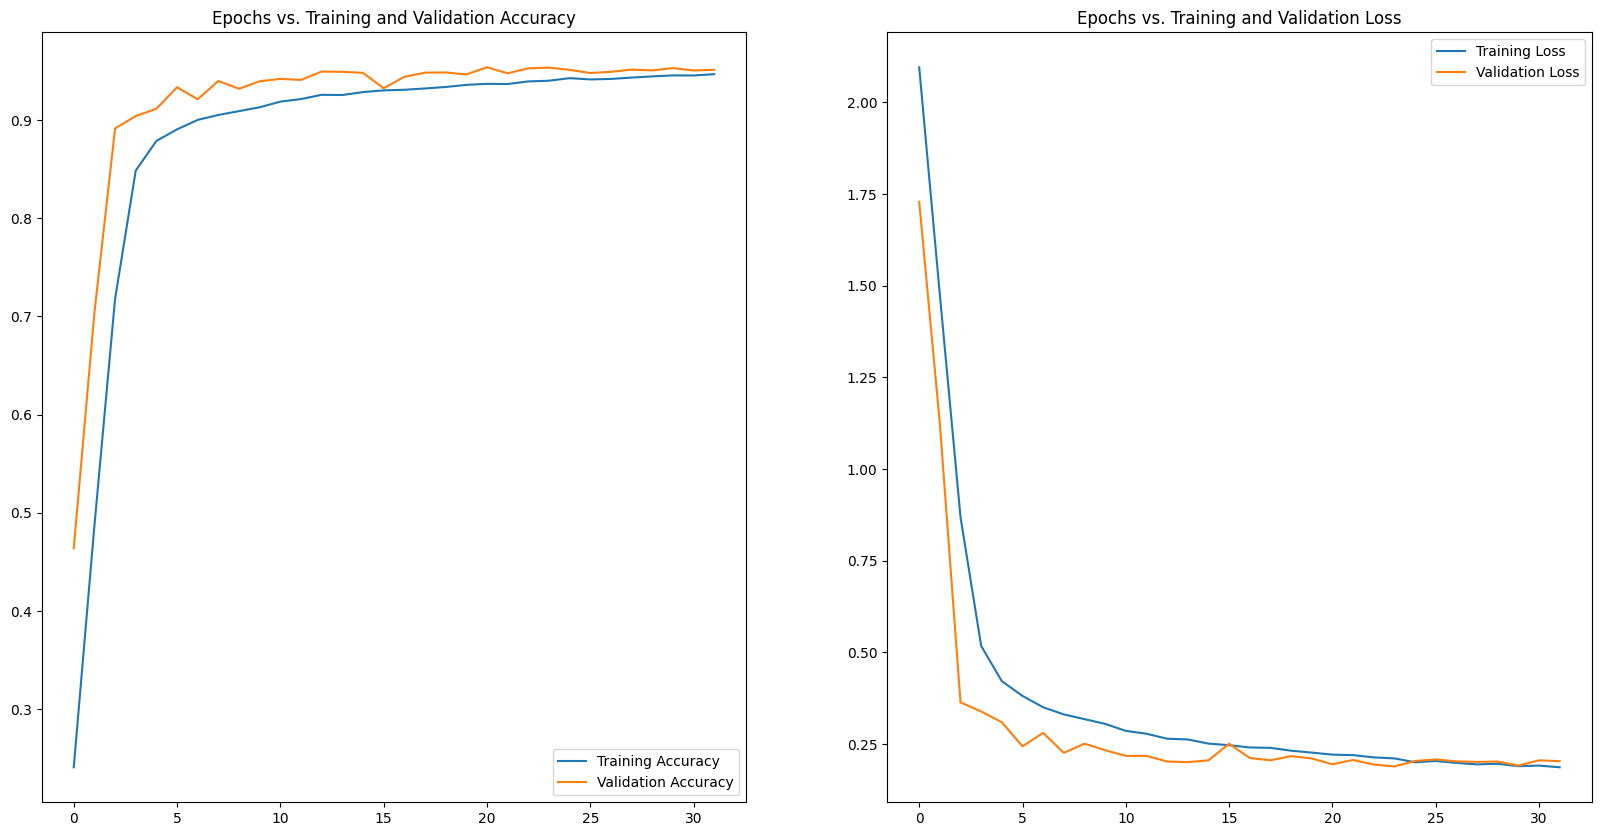

In [ ]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [ ]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9557 
Test loss is: 0.1843


In [ ]:
# Get predictions and apply inverse transformation to the labels

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

1946/1946 [==============================] - 34s 17ms/step


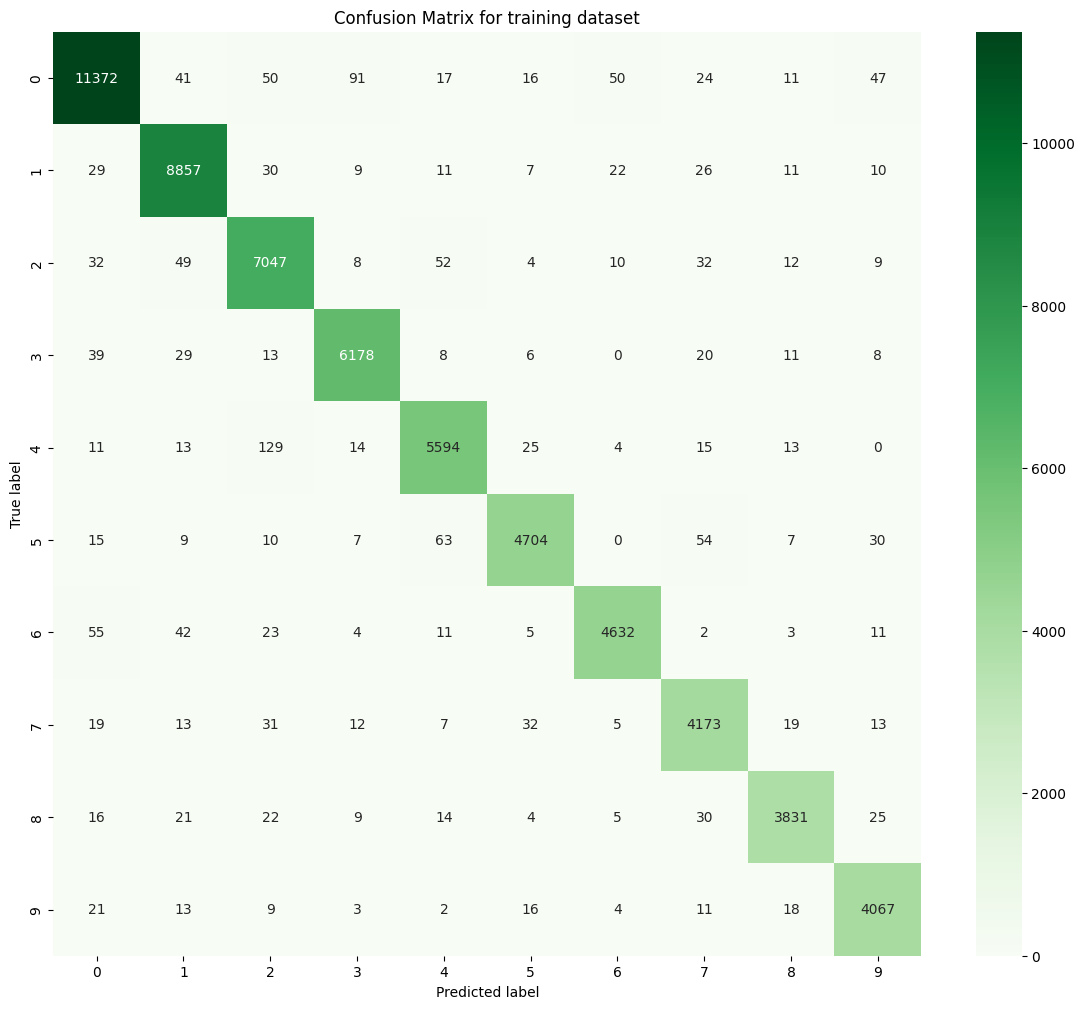

In [ ]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# Ignore the errors in the plots

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
# Get convolutional layers

layers = [model.get_layer('conv2d_1'), 
          model.get_layer('conv2d_2'),
          model.get_layer('conv2d_3'),
          model.get_layer('conv2d_4'),
          model.get_layer('conv2d_5')]
        #   model.get_layer('conv2d_6')]

In [ ]:
# Define a model which gives the outputs of the layers

layer_outputs = [layer.output for layer in layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
# Create a list with the names of the layers

layer_names = []
for layer in layers:
    layer_names.append(layer.name)


In [ ]:
# Define a function which will plot the convolutional filters

def plot_convolutional_filters(img):
    
    img = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img)
    images_per_row = 9
    
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')

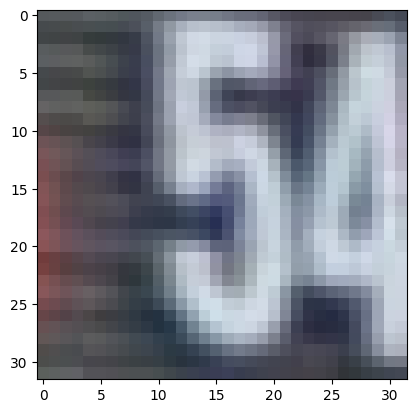

In [ ]:
img = X_train[42500]
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 59ms/step


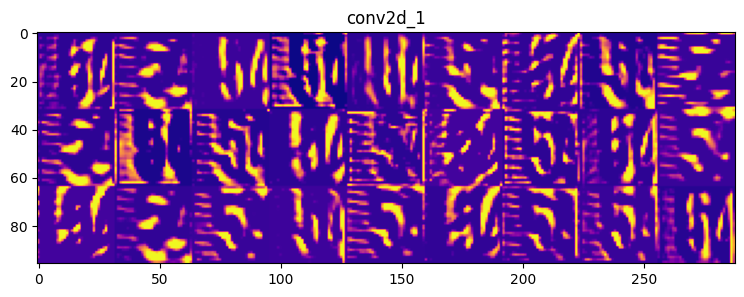

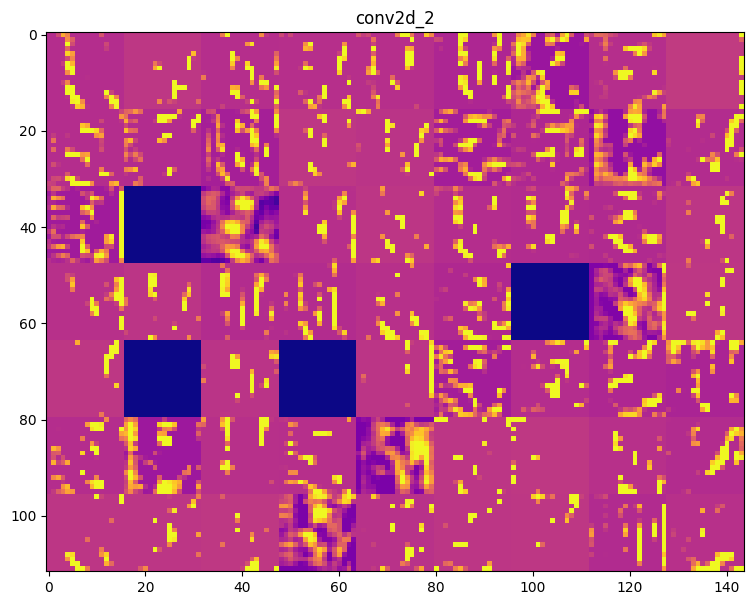

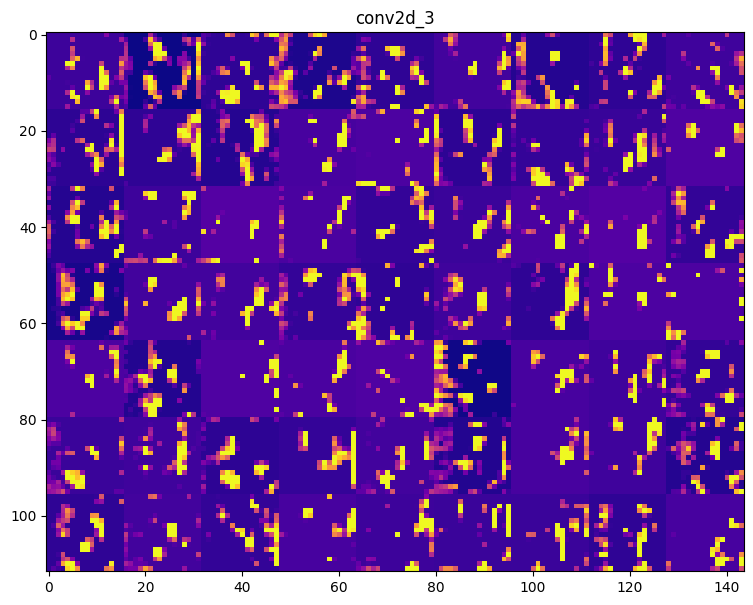

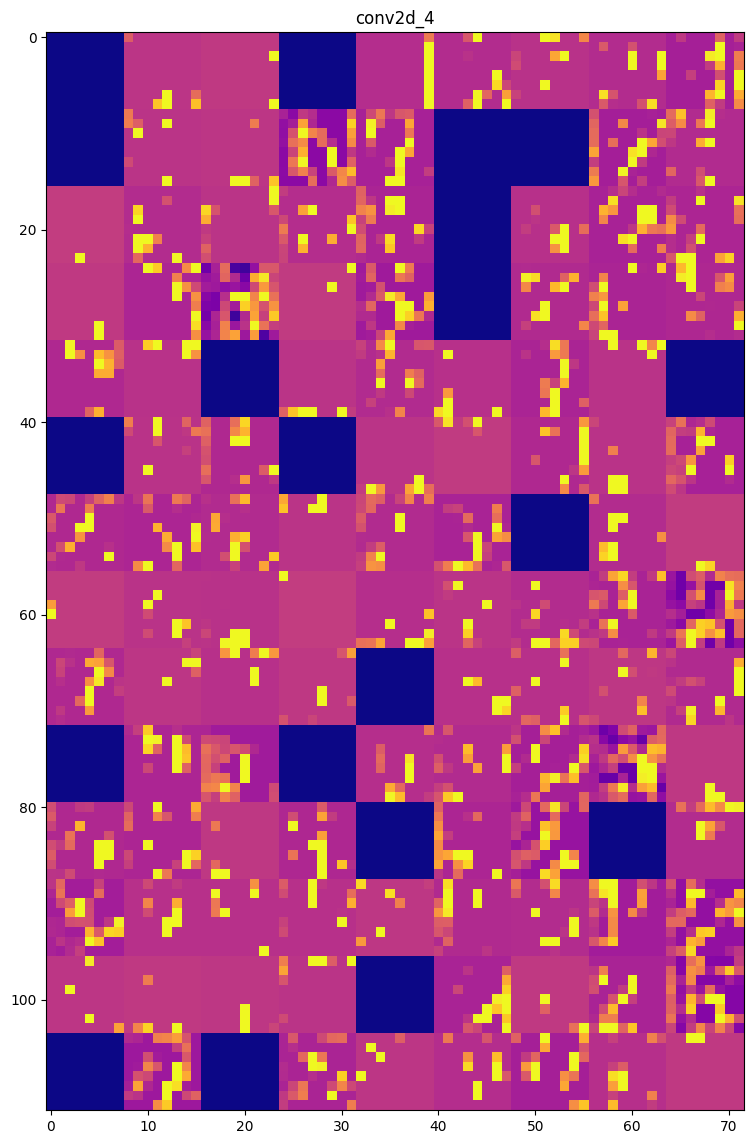

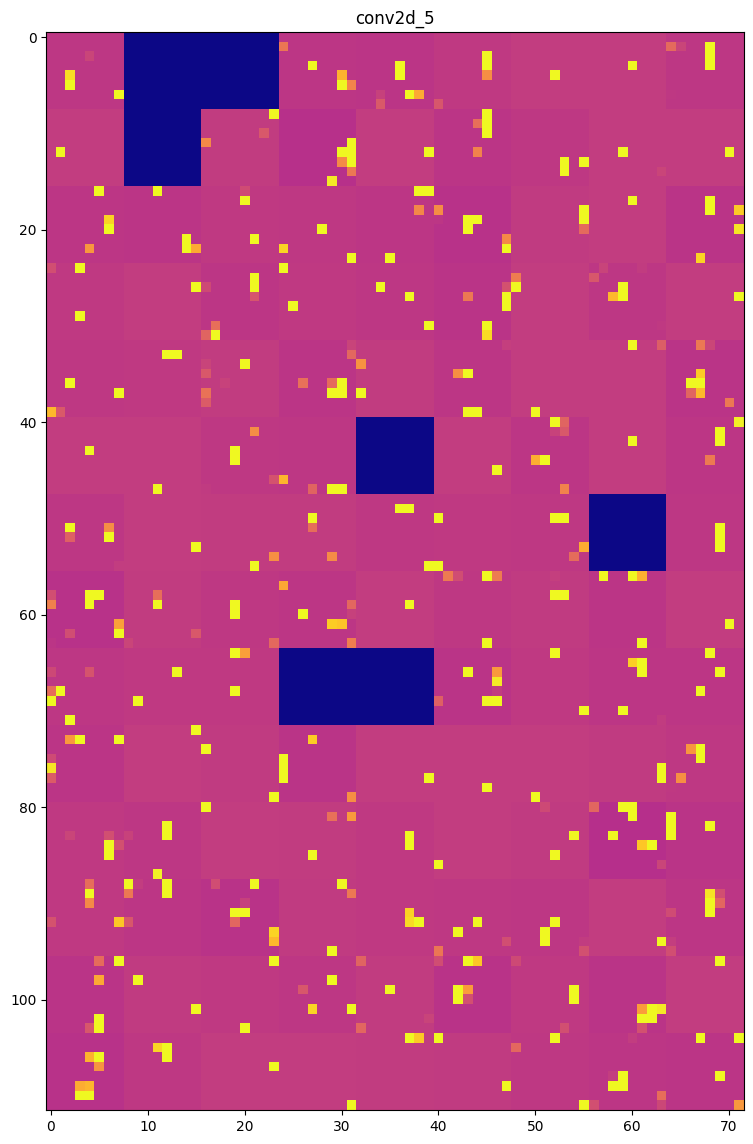

In [ ]:
plot_convolutional_filters(img)